In [1]:
from datasets.get_datasets import *
from revision import *
from boostsrl import boostsrl
import random

## Parameters

In [14]:
target = 'athleteplaysforteam'
test_size = 0.3
small_train_size = 0.3
validation_size = 0.2
revision_threshold = 0.95
max_revision_iterations = 10

## Dataset

In [3]:
[facts, pos, neg] = get_nell_dataset(target)

## Background  configuration

In [4]:
bk = ['athleteledsportsteam(+athlete,+sportsteam).',
      'athleteledsportsteam(+athlete,-sportsteam).',
      'athleteledsportsteam(-athlete,+sportsteam).',
      'athleteplaysforteam(+athlete,+sportsteam).',
      'athleteplaysforteam(+athlete,-sportsteam).',
      'athleteplaysforteam(-athlete,+sportsteam).',
      'athleteplaysinleague(+athlete,+sportsleague).',
      'athleteplaysinleague(+athlete,-sportsleague).',
      'athleteplaysinleague(-athlete,+sportsleague).',
      'athleteplayssport(+athlete,+sport).',
      'athleteplayssport(+athlete,-sport).',
      'athleteplayssport(-athlete,+sport).',
      'teamalsoknownas(+sportsteam,+sportsteam).',
      'teamalsoknownas(+sportsteam,-sportsteam).',
      'teamalsoknownas(-sportsteam,+sportsteam).',
      'teamplaysagainstteam(+sportsteam,+sportsteam).',
      'teamplaysagainstteam(+sportsteam,-sportsteam).',
      'teamplaysagainstteam(-sportsteam,+sportsteam).',
      'teamplaysinleague(+sportsteam,+sportsleague).',
      'teamplaysinleague(+sportsteam,-sportsleague).',
      'teamplaysinleague(-sportsteam,+sportsleague).',
      'teamplayssport(+sportsteam,+sport).',
      'teamplayssport(+sportsteam,-sport).',
      'teamplayssport(-sportsteam,+sport).']

background = boostsrl.modes(bk, [target], useStdLogicVariables=False, treeDepth=8, nodeSize=3, numOfClauses=8)

## Sampling examples

In [5]:
# shuffle all examples
random.shuffle(pos)
random.shuffle(neg)

# separate train and test
test_pos = pos[:int(test_size*len(pos))]
test_neg = neg[:int(test_size*len(neg))]
train_pos = pos[int(test_size*len(pos)):]
train_neg = neg[int(test_size*len(neg)):]

# learn from scratch in a small dataset
s_train_pos = train_pos[:int(small_train_size*len(train_pos))]
s_train_neg = train_neg[:int(small_train_size*len(train_neg))]

# shuffle all train examples
random.shuffle(train_pos)
random.shuffle(train_neg)

# train set used in revision and validation set
r_train_pos = train_pos[int(validation_size*len(train_pos)):]
r_train_neg = train_neg[int(validation_size*len(train_neg)):]
validation_pos = train_pos[:int(validation_size*len(train_pos))]
validation_neg = train_neg[:int(validation_size*len(train_neg))]

print('Total examples')
print('Positive examples: %s' % len(pos))
print('Negative examples: %s' % len(neg))
print('\n')
print('Train and test sets from total')
print('Train Positive examples: %s' % len(train_pos))
print('Train Negative examples: %s' % len(train_neg))
print('Test Positive examples: %s' % len(test_pos))
print('Test Negative examples: %s' % len(test_neg))
print('\n')
print('Small dataset')
print('Train Positive examples: %s' % len(s_train_pos))
print('Train Negative examples: %s' % len(s_train_neg))
print('\n')
print('Revision theory train dataset and validation')
print('Train Positive examples: %s' % len(r_train_pos))
print('Train Negative examples: %s' % len(r_train_neg))
print('Validation Positive examples: %s' % len(validation_pos))
print('Validation Negative examples: %s' % len(validation_neg))

Total examples
Positive examples: 1458
Negative examples: 1458


Train and test sets from total
Train Positive examples: 1021
Train Negative examples: 1021
Test Positive examples: 437
Test Negative examples: 437


Small dataset
Train Positive examples: 306
Train Negative examples: 306


Revision theory train dataset and validation
Train Positive examples: 817
Train Negative examples: 817
Validation Positive examples: 204
Validation Negative examples: 204


## Learning from small dataset

WILL-Produced Tree:
% FOR athleteplaysforteam(A, B):
%   if ( athleteledsportsteam(C, B), athleteplaysinleague(C, D), athleteplaysinleague(A, D) )
%   then return 0.7164166516349435;  // std dev = 0,349, 127,000 (wgt'ed) examples reached here.  /* #neg=18 #pos=109 */
%   else if ( athleteplaysinleague(A, E) )
%   | then return -0.014578337627760393;  // std dev = 0,333, 110,000 (wgt'ed) examples reached here.  /* #neg=96 #pos=14 */
%   | else if ( teamplaysagainstteam(B, F), teamalsoknownas(G, F) )
%   | | then if ( athleteledsportsteam(H, G), teamplaysinleague(B, I), teamplaysagainstteam(F, B) )
%   | | | then if ( athleteledsportsteam(A, B) )
%   | | | | then return 0.8581489350995121;  // std dev = 5,96e-08, 22,000 (wgt'ed) examples reached here.  /* #pos=22 */
%   | | | | else if ( teamplaysagainstteam(B, G), teamalsoknownas(B, F) )
%   | | | | | then return 0.8081489350995122;  // std dev = 0,975, 20,000 (wgt'ed) examples reached here.  /* #neg=1 #pos=19 */
%   | | | | | else retu

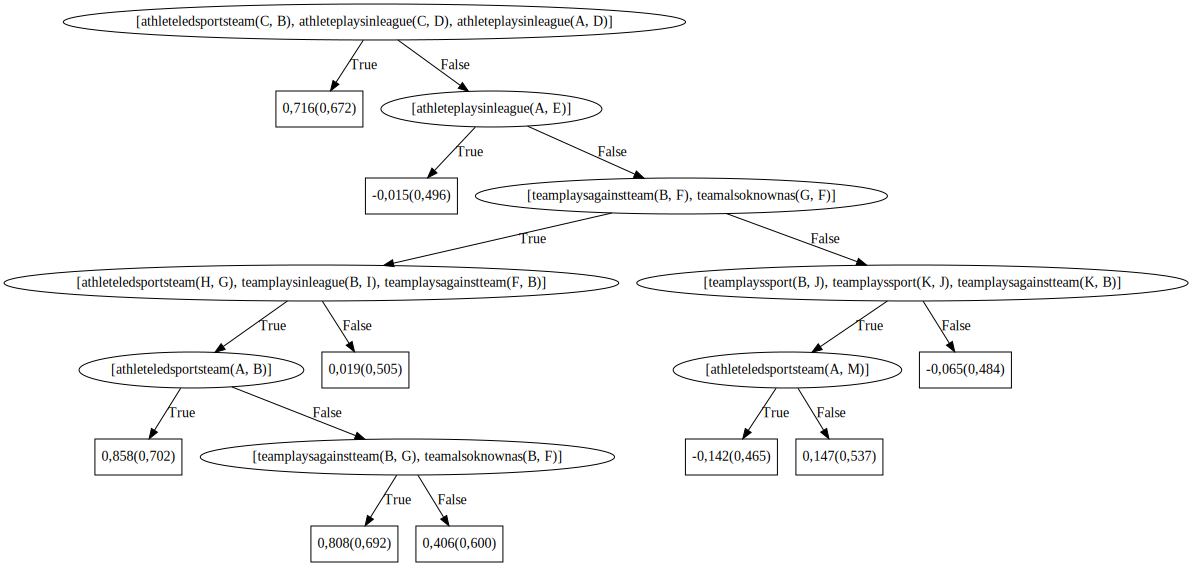

In [6]:
delete_model_files()
model = boostsrl.train(background, s_train_pos, s_train_neg, facts)
learning_time = model.traintime()
will = model.get_will_produced_tree()
structured = model.get_structured_tree().copy()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total learning time: %s seconds' % learning_time)
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
print('Tree:')
model.tree(0, target, image=True)

## Learning from complete dataset

WILL-Produced Tree:
% FOR athleteplaysforteam(A, B):
%   if ( athleteledsportsteam(C, B), athleteplaysinleague(C, D), athleteplaysinleague(A, D) )
%   then return 0.7106489350995082;  // std dev = 0,355, 400,000 (wgt'ed) examples reached here.  /* #neg=59 #pos=341 */
%   else if ( athleteplaysinleague(A, E), teamplaysinleague(F, E) )
%   | then return 0.006207187526697017;  // std dev = 0,355, 412,000 (wgt'ed) examples reached here.  /* #neg=351 #pos=61 */
%   | else if ( teamplaysinleague(B, G), teamplaysagainstteam(H, B), teamalsoknownas(I, H) )
%   | | then if ( athleteledsportsteam(A, B) )
%   | | | then return 0.8581489350995126;  // std dev = 0,000, 64,000 (wgt'ed) examples reached here.  /* #pos=64 */
%   | | | else if ( teamplaysagainstteam(B, I), teamplaysagainstteam(B, H) )
%   | | | | then if ( teamplaysagainstteam(I, B), teamplayssport(B, J) )
%   | | | | | then return 0.44638422921715504;  // std dev = 11,114, 510,000 (wgt'ed) examples reached here.  /* #neg=210 #pos=300 *

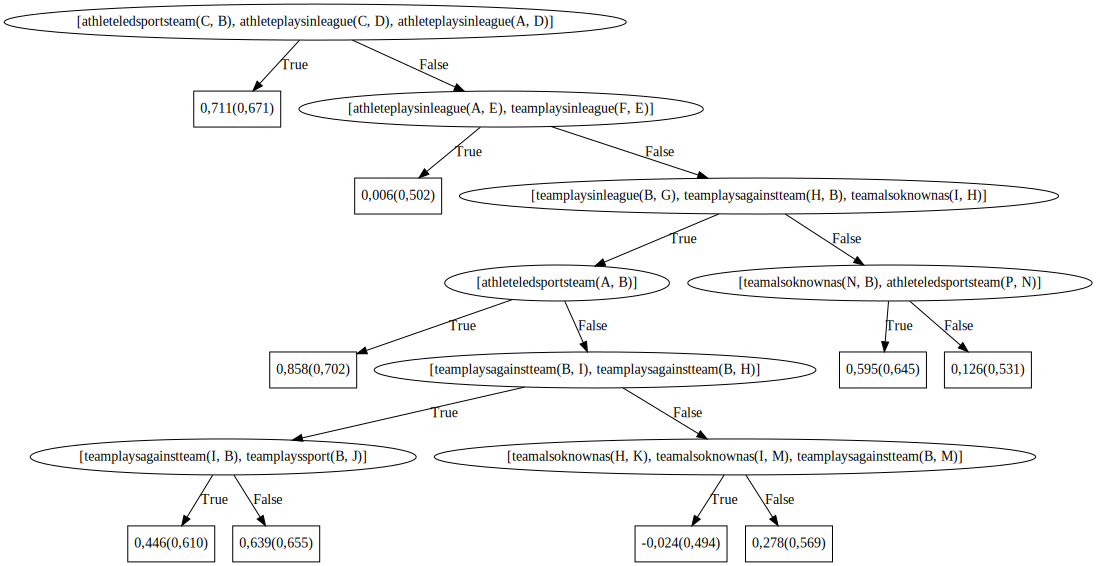

In [7]:
delete_model_files()
model = boostsrl.train(background, train_pos, train_neg, facts)
learning_time = model.traintime()
will = model.get_will_produced_tree()
#structured = model.get_structured_tree().copy()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total learning time: %s seconds' % learning_time)
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
print('Tree:')
model.tree(0, target, image=True)

## Theory Revision

Performing parameter learning
******************************************
WILL-Produced Tree:
% FOR athleteplaysforteam(A, B):
%   if ( athleteledsportsteam(C, B), athleteplaysinleague(C, D), athleteplaysinleague(A, D) )
%   then return 0.7035436719416137;  // std dev = 6,303, 304,000 (wgt'ed) examples reached here.  /* #neg=47 #pos=257 */
%   else if ( athleteplaysinleague(A, E) )
%   | then return 0.013321348892615782;  // std dev = 6,754, 348,000 (wgt'ed) examples reached here.  /* #neg=294 #pos=54 */
%   | else if ( teamplaysagainstteam(B, F), teamalsoknownas(G, F) )
%   | | then if ( athleteledsportsteam(H, G), teamplaysinleague(B, I), teamplaysagainstteam(F, B) )
%   | | | then if ( athleteledsportsteam(A, B) )
%   | | | | then return 0.8581489350995122;  // std dev = 1,46e-07, 50,000 (wgt'ed) examples reached here.  /* #pos=50 */
%   | | | | else if ( teamplaysagainstteam(B, G), teamalsoknownas(B, F) )
%   | | | | | then return 0.5414822684328459;  // std dev = 3,603, 60,000 (wgt

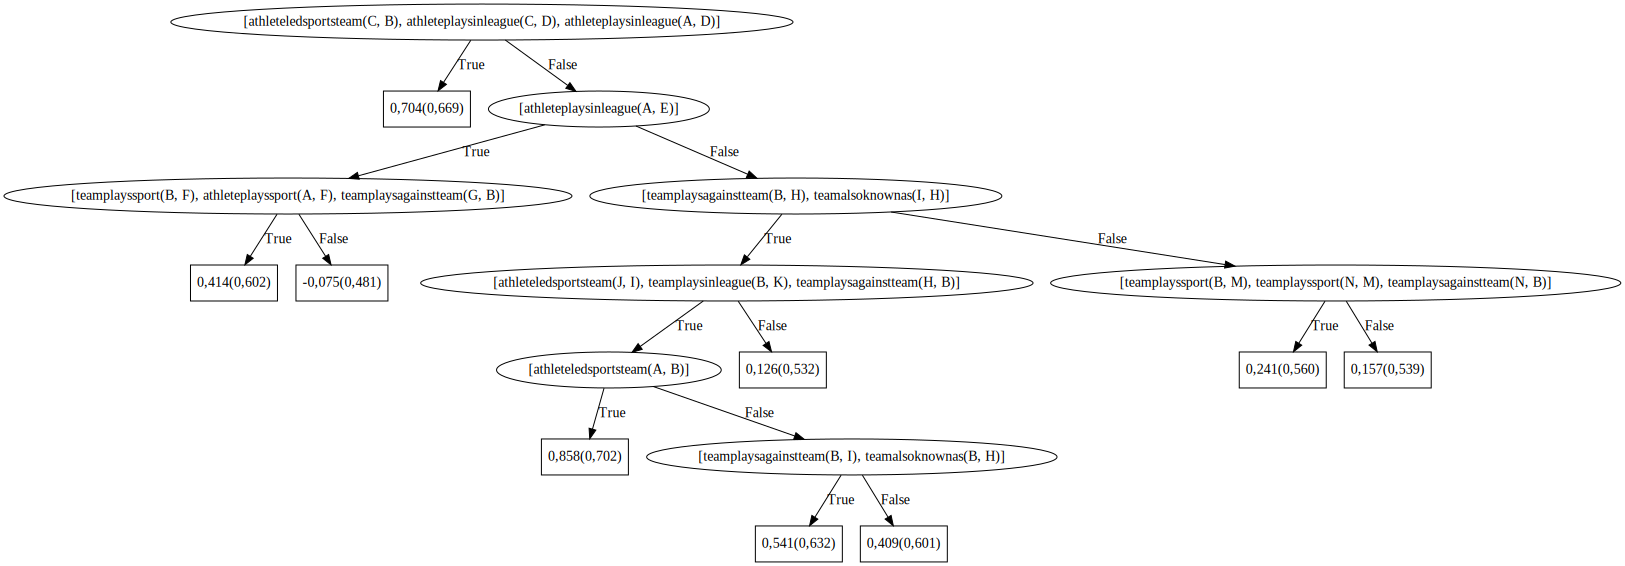

In [15]:
total_revision_time = 0
best_aucroc = 0
best_structured = None

print('Performing parameter learning')
print('******************************************')
delete_model_files()
model = boostsrl.train(background, r_train_pos, r_train_neg, facts, refine=get_refine_file(structured))
learning_time = model.traintime()
will = model.get_will_produced_tree()
structured = model.get_structured_tree().copy()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
total_revision_time += learning_time + inference_time
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total learning time: %s seconds' % learning_time)
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
#print('Tree:')
#model.tree(0, target, image=True)

best_aucroc = t_results['AUC ROC']
best_structured = structured.copy()
save_model_files()

for i in range(max_revision_iterations):
    print('Refining iteration %s' % str(i+1))
    print('******************************************')
    found_better = False
    for candidate in get_cantidates(best_structured, revision_threshold):
        print('Refining node candidate')
        print('******************************************')
        delete_model_files()
        model = boostsrl.train(background, r_train_pos, r_train_neg, facts, refine=candidate)
        learning_time = model.traintime()
        will = model.get_will_produced_tree()
        results = boostsrl.test(model, test_pos, test_neg, facts)
        inference_time = results.testtime()
        t_results = results.summarize_results()
        total_revision_time += learning_time + inference_time
        print('WILL-Produced Tree:')
        print_will_produced_tree(will)
        print('\n')
        print('Results:')
        print(t_results)
        print('\n')
        print('Total learning time: %s seconds' % learning_time)
        print('Total inference time: %s seconds' % inference_time)
        print('AUC ROC: %s' % t_results['AUC ROC'])
        print('\n')
        #print('Tree:')
        #model.tree(0, target, image=True)
        print('******************************************')

        if t_results['AUC ROC'] > best_aucroc:
            found_better = True
            best_aucroc = t_results['AUC ROC']
            best_structured = model.get_structured_tree().copy()
            save_model_files()
    print('Best Tree AUC ROC so far: %s' % best_aucroc)
    print('******************************************\n')
    if found_better == False:
        break

print('******************************************')
delete_model_files()
get_saved_model_files()
delete_test_files()
print('Total revision time: %s' % total_revision_time)
print('Best validation AUC ROC: %s' % best_aucroc)
will = model.get_will_produced_tree()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
print('Tree:')
model.tree(0, target, image=True)